# Comparing clustering algorithms with Motion Capture data

This is just the temporary version of the report.

## 1. Loading the MoCap dataset
The dataset can be dowloaded from https://archive.ics.uci.edu/ml/datasets/MoCap+Hand+Postures



In [1]:
# importing the relevant libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pylab as pil

In [2]:
dat = pd.read_csv('mocap.csv')
dat.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?


In [3]:
# the first row can be removed (see dataset description)
dat = dat.iloc[1:]
dat.reset_index
dat.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?
5,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,...,?,?,?,?,?,?,?,?,?,?


A useful link on how to get rid of the question marks https://stackoverflow.com/questions/35682719/drop-rows-with-a-question-mark-value-in-any-column-in-a-pandas-dataframe

In [4]:
dat2 = dat.replace({'?':np.nan}).dropna().astype(float)
dat2.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
15303,2.0,2.0,27.418588,148.216120,14.770587,49.129027,99.723134,0.883278,92.301344,43.900549,...,7.015468,100.841332,65.337892,-54.651373,77.932709,16.487276,-60.048174,16.113686,-42.471264,-3.140685
15304,2.0,2.0,99.817462,65.686670,-55.457478,57.653306,152.188853,6.644935,92.276726,43.845759,...,14.037669,-1.211737,88.672706,10.187398,16.482357,-42.641627,-2.050853,2.582169,127.945490,11.415229
36818,2.0,9.0,71.944991,135.565802,-27.782710,86.536958,66.145021,-39.206386,30.328132,102.824000,...,2.384311,16.416635,127.743800,-19.398255,6.713694,90.193203,-13.508942,84.104979,44.247865,-45.390036
36819,2.0,9.0,86.346749,66.590273,-38.629277,71.496851,90.724686,-28.165732,51.263880,99.415833,...,-12.430796,78.022520,15.748048,-54.007325,4.626282,26.219870,2.409990,84.350011,44.798182,-44.880864
36820,2.0,9.0,72.541023,91.001656,-26.329067,87.507036,67.629524,-36.272075,71.195968,135.058671,...,-54.063723,40.442153,154.436985,-6.757292,83.578826,44.363539,-45.550582,5.494588,26.766967,3.806395


In [5]:
y = dat2['Class']

In [6]:
np.unique(y)

array([ 2.])

However, as we can see we are keeping only one type of hand posture. What to do?

In [7]:
#dat3 = dat.drop(['X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10','Z10', 'X11', 'Y11', 'Z11'], axis=1)
dat3 = dat.drop(['X9', 'Y9', 'Z9', 'X10', 'Y10','Z10', 'X11', 'Y11', 'Z11'], axis=1)
dat3.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z5,X6,Y6,Z6,X7,Y7,Z7,X8,Y8,Z8
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?
5,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,...,?,?,?,?,?,?,?,?,?,?


In [8]:
dat3 = dat3.replace({'?':np.nan}).dropna().astype(float)
dat3.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z5,X6,Y6,Z6,X7,Y7,Z7,X8,Y8,Z8
1873,2.0,0.0,63.554969,98.490988,11.165920,49.159831,154.330730,32.004168,92.793124,137.143202,...,-71.713081,12.660462,95.077144,29.664434,84.110115,151.545456,16.891147,79.185592,54.753463,-72.462285
1874,2.0,0.0,80.873812,93.722537,-4.988816,63.572103,98.476638,11.242908,49.142700,154.347050,...,35.349247,92.942044,137.182817,1.297511,35.480104,99.739019,22.802243,83.936993,151.633126,16.718403
1875,2.0,0.0,80.775150,93.705283,-5.090904,63.479609,98.429524,11.161413,48.924111,154.340338,...,-74.222778,20.499495,132.863377,35.309544,58.297882,27.583892,-71.888449,13.286942,95.053108,30.491436
1876,2.0,0.0,80.618164,93.781461,-5.012812,63.213130,98.462919,11.045095,48.777435,154.327283,...,1.859117,83.404493,151.744359,16.542773,95.314840,73.900253,-73.894505,20.628186,132.787591,35.836072
1877,2.0,0.0,79.870413,93.921192,-5.628231,79.239570,55.197852,-72.374008,48.446947,154.215388,...,-72.683063,83.279689,151.629068,16.999059,58.050614,27.980287,-72.379748,20.453203,132.633282,36.134339


In [9]:
y=dat3['Class']
np.unique(y)

array([ 1.,  2.,  3.,  4.,  5.])

So I think we can use the above dataset as an example

In [10]:
X=np.array(dat3.iloc[:,2:])

In [11]:
X.shape

(30563, 27)

In [84]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size=0.5, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y, test_size=0.5, random_state=0)

In [85]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train1_std = sc.fit_transform(X_train1)
X_train2_std = sc.fit_transform(X_train2)

## 2. KMeans

In [88]:
# we know from the description of the dataset that there are 5 different postures.
# can we reproduce them?
from sklearn.cluster import KMeans
import time
km = KMeans(n_clusters = 5, init = 'k-means++', n_init=10, max_iter=300, tol=1e-4,random_state=42)
start_time = time.time()
km.fit(X_train1)
end_time = time.time()
print('K-Means++ execution time:')
print("--- %s seconds ---" % (end_time - start_time))

K-Means++ execution time:
--- 0.8106899261474609 seconds ---


In [89]:
y_km = km.predict(X_test1)
np.unique(y_km)

array([0, 1, 2, 3, 4], dtype=int32)

So there are 5 different clusters.

In [90]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true = y_test, y_pred = y_km)

print(confmat)

[[   0    0    0    0    0    0]
 [   2    4   11    6    1    0]
 [ 965 1822 1665 2600  282    0]
 [  14    9    8    7    3    0]
 [ 304  371  164  228  112    0]
 [1039 1218  921 1218 2308    0]]


It's not very diagonal matrix

In [91]:
# now retrieving the data belonging only to one cluster.
dat4 = dat.replace({'?':np.nan}).dropna().astype(float)
dat4.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
15303,2.0,2.0,27.418588,148.216120,14.770587,49.129027,99.723134,0.883278,92.301344,43.900549,...,7.015468,100.841332,65.337892,-54.651373,77.932709,16.487276,-60.048174,16.113686,-42.471264,-3.140685
15304,2.0,2.0,99.817462,65.686670,-55.457478,57.653306,152.188853,6.644935,92.276726,43.845759,...,14.037669,-1.211737,88.672706,10.187398,16.482357,-42.641627,-2.050853,2.582169,127.945490,11.415229
36818,2.0,9.0,71.944991,135.565802,-27.782710,86.536958,66.145021,-39.206386,30.328132,102.824000,...,2.384311,16.416635,127.743800,-19.398255,6.713694,90.193203,-13.508942,84.104979,44.247865,-45.390036
36819,2.0,9.0,86.346749,66.590273,-38.629277,71.496851,90.724686,-28.165732,51.263880,99.415833,...,-12.430796,78.022520,15.748048,-54.007325,4.626282,26.219870,2.409990,84.350011,44.798182,-44.880864
36820,2.0,9.0,72.541023,91.001656,-26.329067,87.507036,67.629524,-36.272075,71.195968,135.058671,...,-54.063723,40.442153,154.436985,-6.757292,83.578826,44.363539,-45.550582,5.494588,26.766967,3.806395


In [92]:
y4 = np.array(dat4['Class'])

In [93]:
np.unique(y4)

array([ 2.])

In [94]:
dat4 = dat4.drop(['X9', 'Y9', 'Z9', 'X10', 'Y10','Z10', 'X11', 'Y11', 'Z11'], axis=1)

In [95]:
dat4.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z5,X6,Y6,Z6,X7,Y7,Z7,X8,Y8,Z8
15303,2.0,2.0,27.418588,148.216120,14.770587,49.129027,99.723134,0.883278,92.301344,43.900549,...,-13.927111,26.918575,96.473093,7.943128,2.713287,128.110776,12.249793,57.712082,152.482286,7.015468
15304,2.0,2.0,99.817462,65.686670,-55.457478,57.653306,152.188853,6.644935,92.276726,43.845759,...,-59.970008,25.734719,96.820081,6.548833,50.689160,98.715470,2.405460,26.914463,148.439662,14.037669
36818,2.0,9.0,71.944991,135.565802,-27.782710,86.536958,66.145021,-39.206386,30.328132,102.824000,...,-28.889918,39.269487,154.228493,-10.139208,76.943159,14.632435,-55.229815,4.498580,26.380901,2.384311
36819,2.0,9.0,86.346749,66.590273,-38.629277,71.496851,90.724686,-28.165732,51.263880,99.415833,...,-19.683871,60.146068,155.526863,-15.275475,39.462353,154.439961,-9.055373,7.065014,90.432980,-12.430796
36820,2.0,9.0,72.541023,91.001656,-26.329067,87.507036,67.629524,-36.272075,71.195968,135.058671,...,-16.148706,29.429498,101.610880,-10.343133,60.453276,155.034340,-13.923854,77.871421,16.185150,-54.063723


In [96]:
X4=np.array(dat4.iloc[:,2:])

In [97]:
y_km4=km.predict(X4)

In [98]:
np.unique(y_km4)
y_km4

array([2, 0, 1, 4, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [99]:
accuracy = (y_km4 == 4).sum()/len(y_km4)
print(accuracy)

0.838709677419


The above should be a single valued array, since I selected samples from one class only.


### 2.1. Elbow method

Let's use the elbow method for the best number of cluster. Adapted from https://www.packtpub.com/big-data-and-business-intelligence/python-machine-learning-second-edition

In [109]:
distorsions1 = []
distorsions2 = []
for i in range(1,11):
    km1 =KMeans(n_clusters=i,
              init='k-means++',
              n_init=10,
              max_iter=300,
              random_state=42)
    km2 =KMeans(n_clusters=i,
              init='k-means++',
              n_init=10,
              max_iter=300,
              random_state=0)
    km1.fit(X_train1)
    distorsions1.append(km1.inertia_)
    km2.fit(X_train2)
    distorsions2.append(km2.inertia_)

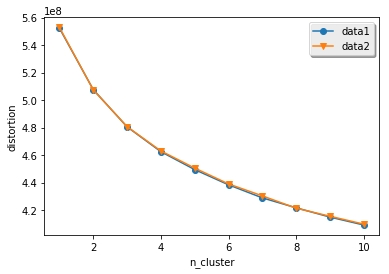

In [110]:
plt.plot(range(1,11), distorsions1, marker='o', label = 'data1')
plt.plot(range(1,11), distorsions2, marker = 'v', label = 'data2')
plt.xlabel('n_cluster')
plt.ylabel('distortion')
plt.legend(loc='upper right', shadow=True)
pil.savefig('elbow_kmeans.pdf', bbox_inches='tight')
plt.show()

It looks like that there is no optimal number of clusters.. Maybe the KMeans algorithm is not good for this purpose.

### 2.1. CH score:

Let's try have a look at the CH score.

In [111]:
from sklearn.metrics import calinski_harabaz_score

scores = []
for i in range(2,11):
    km =KMeans(n_clusters=i,
              init='k-means++',
              n_init=10,
              max_iter=300,
              random_state=42)
    y_km = km.fit_predict(X_train1)
    
    score = calinski_harabaz_score(X_train1, y_km)
    scores.append(score)

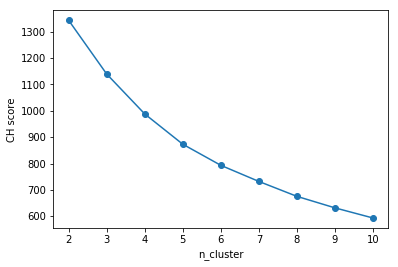

In [112]:
plt.plot(range(2,11), scores, marker='o')
plt.xlabel('n_cluster')
plt.ylabel('CH score')
pil.savefig('chscore_kmeans.pdf', bbox_inches='tight')
plt.show()

Even this one does not tell me anything in particular.

## 3. Agglomerative Clustering

This is the bottom-up approach to hierarchical clustering

In [113]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=5,
                            affinity = 'euclidean',
                            linkage='complete')

In [116]:
start_time = time.time()
y_ac = ac.fit_predict(X_train1)
end_time = time.time()
print('Agglomerative Clustering execution time:')
print("--- %s seconds ---" % (end_time - start_time))

Agglomerative Clustering execution time:
--- 13.376217126846313 seconds ---


In [117]:
np.unique(y_ac)

array([0, 1, 2, 3, 4])

In [118]:
### here I want to check how well the Agglomerative clustering is doing
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true = y_train, y_pred = y_ac)

In [119]:
print(confmat)

[[   0    0    0    0    0    0]
 [  16    7    0    0    1    0]
 [5638 1160    6   17  395    0]
 [  31    7    0    0    2    0]
 [ 889  204    0    0   77    0]
 [5354 1022    0    0  455    0]]


### 3.1. CH-score

In [120]:
from sklearn.metrics import calinski_harabaz_score

scores1 = []
scores2 = []
for i in range(2,11):
    ac1 =AgglomerativeClustering(n_clusters=i,
                                affinity='euclidean',
                                linkage='complete')
    ac2 =AgglomerativeClustering(n_clusters=i,
                                affinity='euclidean',
                                linkage='complete')
    
    
    y_ac1 = ac1.fit_predict(X_train1_std)
    y_ac2 = ac2.fit_predict(X_train2_std)
    
    score1 = calinski_harabaz_score(X_train1_std, y_ac1)
    scores1.append(score1)
    score2 = calinski_harabaz_score(X_train2_std, y_ac2)
    scores2.append(score2)

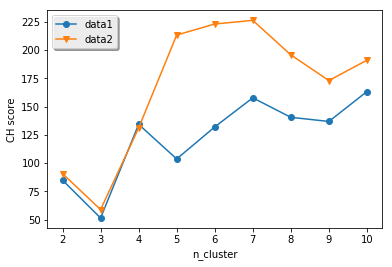

In [121]:
plt.plot(range(2,11), scores1, marker='o', label='data1')
plt.plot(range(2,11), scores2, marker='v', label='data2')
plt.xlabel('n_cluster')
plt.ylabel('CH score')
plt.legend(loc='upper left',shadow=True)
pil.savefig('chscore_agglom.pdf', bbox_inches='tight')
plt.show()

So it looks that the agglomerative clustering cannot successfully detect that the optimal number of clusters. The confusion matrix is also not optimal.

## 4. DBSCAN 

I am facing issues in DBSCAN. It cannot divide the dataset in different clusters.

In [122]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.0000001,
           min_samples=20,
           metric='euclidean')

In [123]:
y_db = db.fit_predict(X_train)

In [124]:
np.unique(y_db)

array([-1])

In [ ]:
# I tried several things but I had no look.
for i in range(1,1001):
    db = DBSCAN(eps=0.00001*i,
           min_samples=10,
           metric='euclidean')
    y_db = db.fit_predict(X_train)
    n_clusters = len(np.unique(y_db))
    if (n_clusters>1):
        print('eps:',0.001*i, 'n_clusters', n_clusters)

## 5. HDBSCAN

In [126]:
import hdbscan

hdb = hdbscan.HDBSCAN(min_cluster_size=20)

start_time = time.time()
cluster_labels = hdb.fit_predict(X_train_std)
end_time = time.time()
print('HDBSCAN execution time:')
print("--- %s seconds ---" % (end_time - start_time))


HDBSCAN execution time:
--- 9.595990896224976 seconds ---


In [69]:
np.unique(cluster_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

In [136]:
# too many clusters.. Let's try to tune the hyperparameters.
n_clusters = []

for i in range(30,40):
    hdb = hdbscan.HDBSCAN(min_cluster_size=i)
    cluster_labels = hdb.fit_predict(X_train1_std)
    n_cluster = len(np.unique(cluster_labels))
    n_clusters.append(n_cluster)

### 5.1. Tuning the hyper-parameter

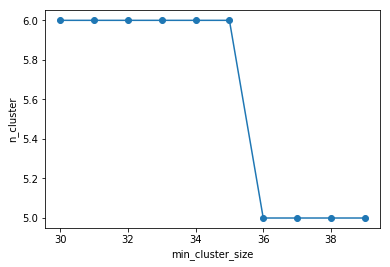

In [140]:
plt.plot(range(30,40), n_clusters, marker='o', label = 'data1')
#plt.plot(range(5,25), n_clusters2, marker='v', label = 'data2')
plt.xlabel('min_cluster_size')
plt.ylabel('n_cluster')
#plt.xlim(5,25)
#plt.legend(loc = 'upper left', shadow = True)
pil.savefig('hdbscan1.pdf', bbox_inches='tight')
plt.show()

### 5.2. CH-index vs min_cluster_size

In [138]:
from sklearn.metrics import calinski_harabaz_score

scores = []
for i in range(30,40):
    hdb = hdbscan.HDBSCAN(min_cluster_size=i)
    y_hdb = hdb.fit_predict(X_train_std)
    score = calinski_harabaz_score(X_train_std, y_hdb)
    scores.append(score)

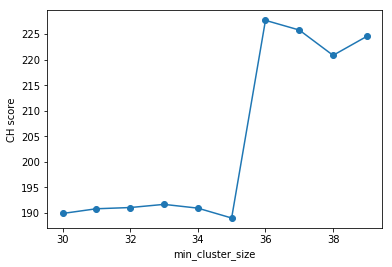

In [139]:
plt.plot(range(30,40), scores, marker='o')
plt.xlabel('min_cluster_size')
plt.ylabel('CH score')
pil.savefig('chscore_hdbscan.pdf', bbox_inches='tight')
plt.show()

This does not help me unfortuntely